# M2: Cross Validating a Linear Regression Model
# DAV 6150

- Group Members: Qing Dou, Ruoyu Chen, Zhengnan Li
- Repository: https://github.com/jc000222/Data_Science_DAV6150/blob/main/M2/M2_Assignment.ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=pd.core.generic.SettingWithCopyWarning)

# 1. Introduction
In this analysis, our goal is to construct a cross-validated linear regression model to predict the weight of a passenger vehicle using a dataset from the UC Irvine machine learning archive.


### 1.1 Approach
We devide the work into 4 steps:
- Introduction: Introduction to the Dataset and Research Question

- Explanatory Data Analysis (EDA):   Clean data, explore and analyze the dataset to uncover patterns and gain insights into its structure. Present overall statistics to provide overview for explanatory variables selection and model building.

- Regression Model Construction & Evaluation:  Construct cross-validated linear regression models based on preprocessed data and assess their performance using appropriate metrics.

- Conclusion: Iteratively refine the models, adjusting approaches as necessary to improve outcomes and meet project goals based on the evaluation results,  

### 1.2 Dataset
The dataset we will be using is sourced from the UC Irvine machine learning archive: https://archive.ics.uci.edu/ml/datasets/Automobile. The data set is comprised of 205 observations and 26 attributes. 
As the assignment requires, the curb-weight variable will serve as the response variable for our regression model. The explanatory variables you may choose from are as follows: height, width, length, wheel-base, 
engine-size, horsepower, peak-rpm, and city-mpg. __All other attributes contained within the data set should be ignored for this Assignment.__  
From the UCI web page we can learn about the details on these variables:

| Attribute    | Type      | Description                                               | Range           |
|--------------|-----------|-----------------------------------------------------------|-----------------|
| Wheel-base   | Numerical | The distance between the front and rear wheels            | 86.6 to 120.9   |
| Height       | Numerical | The height of the vehicle                                 | 47.8 to 59.8    |
| Width        | Numerical | The width of the vehicle                                  | 60.3 to 72.3    |
| Length       | Numerical | The length of the vehicle                                 | 141.1 to 208.1  |
| Engine-size  | Numerical | The displacement of the engine                            | 61 to 326       |
| Horsepower   | Numerical | The power output of the engine                            | 48 to 288       |
| Peak-rpm     | Numerical | The maximum revolutions per minute of the engine          | 4150 to 6600    |
| City-mpg     | Numerical | The vehicle's fuel efficiency in urban areas              | 13 to 49        |
| Curb-weight  | Numerical | The weight of the vehicle without passengers or cargo     | 1488 to 4066    |


Read the data from our github repository and assign the coulumns according to UCI web page. Then select the explanatory and response variable we need in this analysis. The dataframe is shown below.

In [2]:
passager_vehicle_raw = pd.read_csv("https://raw.githubusercontent.com/jc000222/Data_Science_DAV6150/main/M2/src/M2_Data.csv", header=None)
passager_vehicle_raw.columns = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
                 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
                 'wheel-base', 'length', 'width', 'height', 'curb-weight',
                 'engine-type', 'num-of-cylinders', 'engine-size', 'fuel-system',
                 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm',
                 'city-mpg', 'highway-mpg', 'price']

explanatory_variables = ['wheel-base', 'length', 'width', 'height', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg']
response_variable = ['curb-weight']

passager_vehicle = passager_vehicle_raw[[col for col in passager_vehicle_raw.columns if col in explanatory_variables+response_variable]]                 
passager_vehicle

,wheel-base,length,width,height,curb-weight,engine-size,horsepower,peak-rpm,city-mpg
0,88.6,168.8,64.1,48.8,2548,130,111,5000,21
1,88.6,168.8,64.1,48.8,2548,130,111,5000,21
2,94.5,171.2,65.5,52.4,2823,152,154,5000,19
3,99.8,176.6,66.2,54.3,2337,109,102,5500,24
4,99.4,176.6,66.4,54.3,2824,136,115,5500,18
...,...,...,...,...,...,...,...,...,...
200,109.1,188.8,68.9,55.5,2952,141,114,5400,23
201,109.1,188.8,68.8,55.5,3049,141,160,5300,19
202,109.1,188.8,68.9,55.5,3012,173,134,5500,18
203,109.1,188.8,68.9,55.5,3217,145,106,4800,26


### 1.3 Problem Summary
We conduct four different linear regression models and try to evaluate them and find the best model:

1. Choose wheel-base, length, width, and engine-size as explanatory variables.

2. Choose city-mpg, length, width as explanatory variables.

3. Choose wheel-base, engine-size, and horsepower as explanatory variables.

4. Choose  wheel-base, engine-size, horsepower, length, width, and city-mpg as explanatory variables.

# 2. Exploratory Data Analysis

### 2.1 Data Cleaning
Since the columns of the dataset is prespecified, we will start the EDA with data cleaning and analyze the variables in 2.2.

First, check for the null values. We realize the dataset has '?' for null values instead of 'NaN'. In order to filter these '?' in the dataset, we use to_numeric to convert the numeric explanatory variables into numbers, and '?' into NaN.  
There are 2 rows of null values on attribute horsepower and peak-rpm.

wheel-base     0
length         0
width          0
height         0
curb-weight    0
engine-size    0
city-mpg       0
horsepower     2
peak-rpm       2
dtype: int64

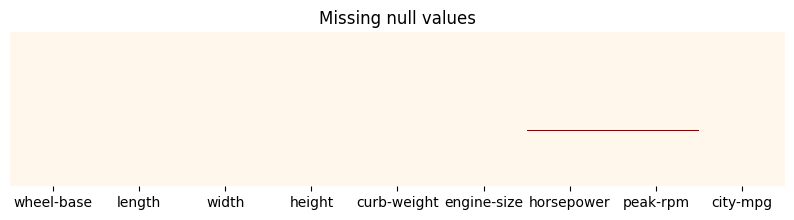

In [3]:
for column in explanatory_variables+response_variable:
    passager_vehicle[column] = pd.to_numeric(passager_vehicle[column], errors='coerce')
plt.rcParams["figure.figsize"] = (10, 2)
sns.heatmap(passager_vehicle.isnull(), yticklabels=False, cbar=False, cmap="OrRd")
plt.title("Missing null values")
passager_vehicle.isnull().sum().sort_values()

Check the 2 rows of null values. We can see the make of the car is renault and indicates that it's the same engine on different car models.  
Search the bore, stroke, engine-size, compression-ratio,4 cylinders OHV engine, the engine basic model seems to be M4R or F4R. But only F4R is both equipped on Renault Clio(hatchback) and Laguna (wagon). Horsepower is about 130hp and peak-rpm differs from 5250 to 6500.

In [4]:
passager_vehicle[passager_vehicle.isnull().any(axis=1)]

,wheel-base,length,width,height,curb-weight,engine-size,horsepower,peak-rpm,city-mpg
130,96.1,181.5,66.5,55.2,2579,132,NaN,NaN,23
131,96.1,176.8,66.6,50.5,2460,132,NaN,NaN,23


Try to replace the null values with mean of the dataset. To make the data more convincing, we choose the num-of-cylinders as 'four', fuel-system as 'mpfi' and fuel-type as 'gas'. We get the Mean of horsepower is 111 and peak-rpm is 5208. This is fairly close to the data we collect online.  
Replace the null value with mean.

In [5]:
conditions =  (passager_vehicle_raw['num-of-cylinders'] == 'four') & \
              (passager_vehicle_raw['fuel-system'] == 'mpfi') & \
              (passager_vehicle_raw['fuel-type'] == 'gas')

for column in ['horsepower', 'peak-rpm']:
    mean_value = passager_vehicle.loc[conditions, column].mean()
    passager_vehicle[column] = passager_vehicle[column].replace('?', np.nan)
    passager_vehicle.loc[conditions & passager_vehicle[column].isnull(), column] = mean_value

    print(f'Mean of {column} : {mean_value}')
passager_vehicle[passager_vehicle_raw['make']=='renault']

Mean of horsepower : 111.65454545454546
Mean of peak-rpm : 5208.181818181818


,wheel-base,length,width,height,curb-weight,engine-size,horsepower,peak-rpm,city-mpg
130,96.1,181.5,66.5,55.2,2579,132,111.654545,5208.181818,23
131,96.1,176.8,66.6,50.5,2460,132,111.654545,5208.181818,23


### 2.2 Prepped Data Overview

Column overview

All the varaibles are numerical variables, so let's first take a look at the data distribution of each column, which can help us understand the data and model.  

wheel-base & length & width & height:  
These variables can be quite related to weight since they indicate the scale of the vehicle. If these variables indicates a bigger scale of the vehicle, it is likely that the more material it takes to build the car and the bigger engine it needs to power the vehicle. And finally results in a bigger weight.  

engine-size:  
The engine is one of the heaviest parts on a vehicle, and therefore it can be a significant factor for predicting the weight. 
horsepower & peak-rpm:  
A greater horsepower often indicates a more powerful and bigger engine, thus can affect the weight of the vehicle. And a higher peak rpm requires the material of the engine to be stronger or it can not take the pressure, so it can also be a factor for deciding the weight of the vehicle.

city-mpg:  
The city environment involves many low speed traffic and requires the vehicle to perform constant acceleration and deceleration. Heavier vehicle can be slower in city environment because the factors such as speed limit and crowded traffic.

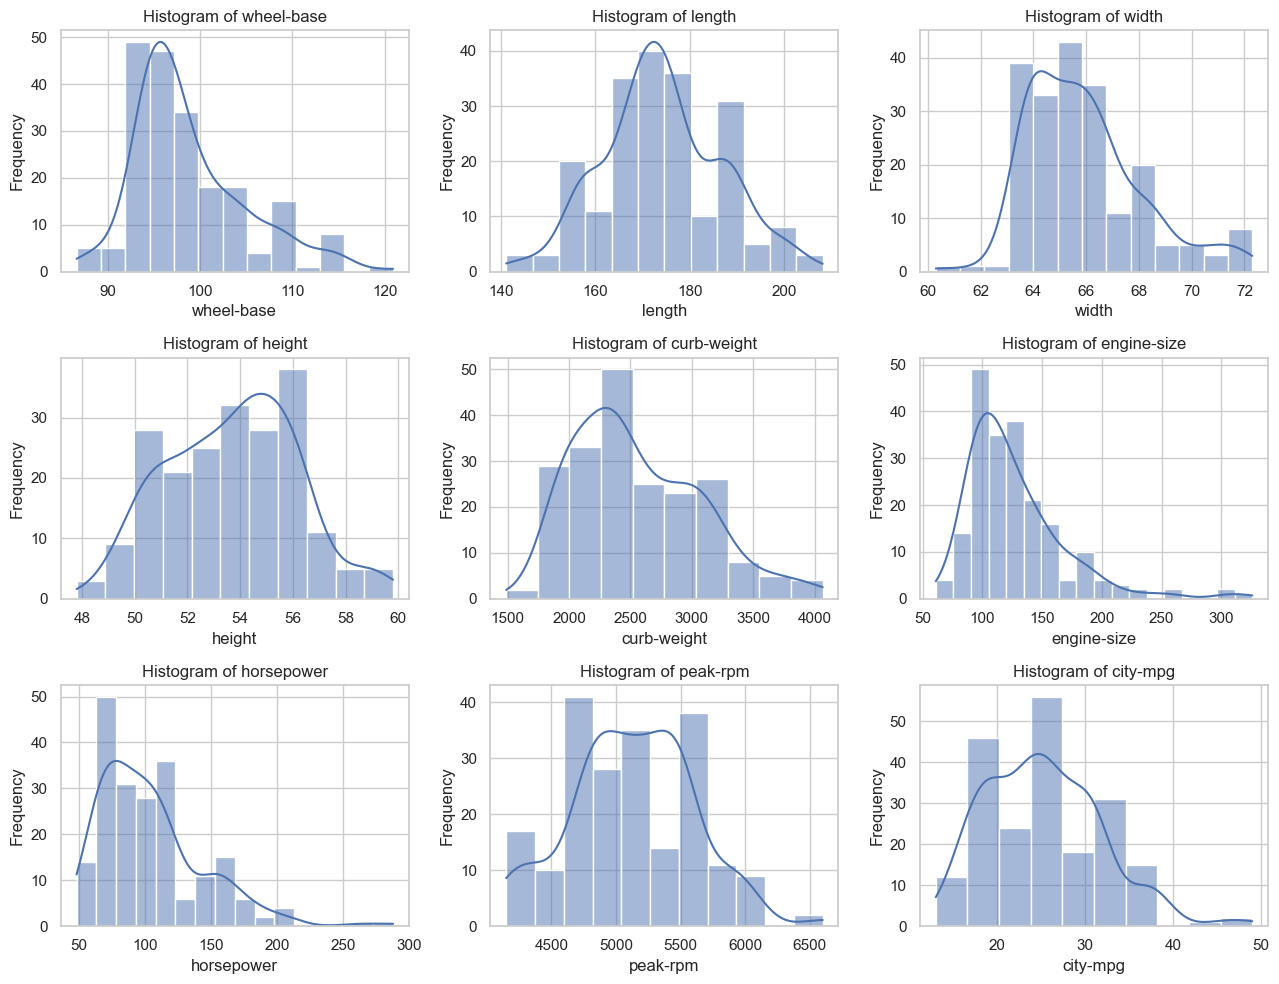

In [6]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
axes = axes.flatten()

for i, column in enumerate(passager_vehicle.columns):
    sns.histplot(passager_vehicle[column], kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

if column in ['horsepower', 'peak-rpm']:
    if column == 'horsepower':
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(10))
    elif column == 'peak-rpm':
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(100))
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=70)
plt.tight_layout()
plt.show()

Then, we look at the relationship between each column and the response variable by calculating the correlation heatmap. It can provide us with some directions for selecting prediction models and variables. The warmer color on the heatmap indicates a positive correlation and colder color indicates a negative correlation.  
It can be seen from the heatmap that wheel-base, length, width, engine-size, and horsepower are positively correlated, and city-mpg is negatively correlated.

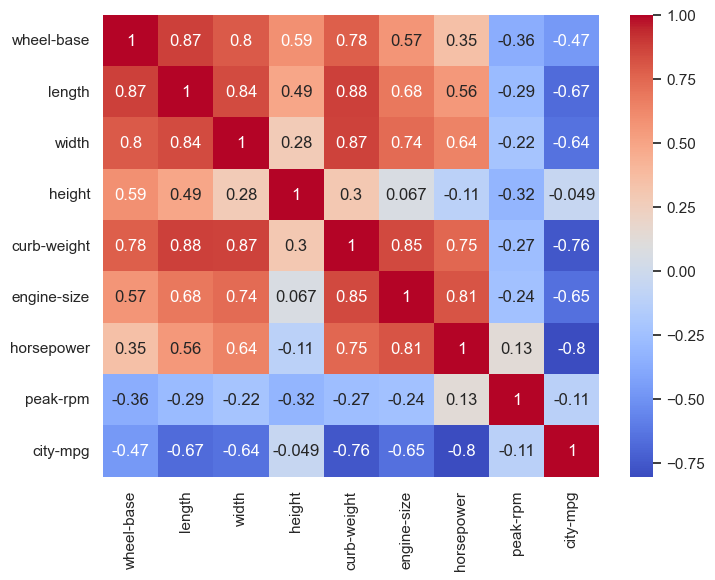

In [7]:
correlation_matrix = passager_vehicle.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

Get a overview of the cleaned dataset. The charts below shows the scatter plot of each explanatory variables and the response variable and the correlation.  
It can be seen that most explanatory variables has a linear correlation with the response variable.

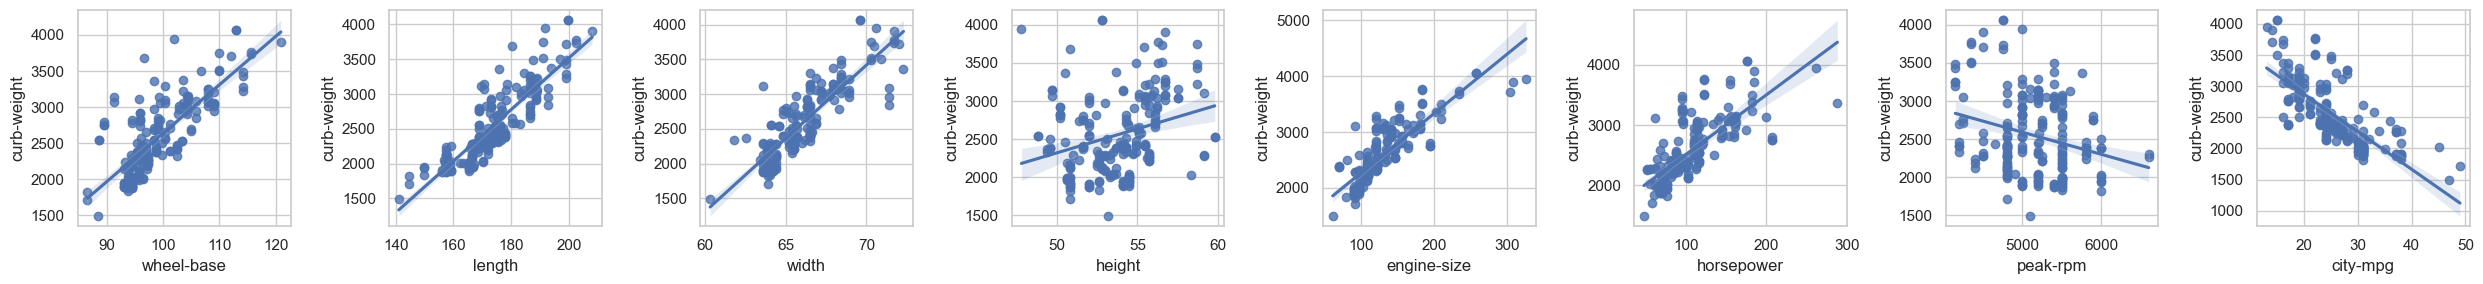

In [8]:
fig, axes = plt.subplots(1,8, figsize=(25,3))

for i, f in enumerate(explanatory_variables):
    sns.regplot(x=f, y='curb-weight', data=passager_vehicle, ax=axes[i])

plt.tight_layout()
plt.show()

# 3 Model Construction
Based on the previous EDA research, we can see that most variables have strong correlation with the curb-weight. In this section we will construct 3 different cross-validated linear regression models to predict the weight of a passenger vehicle and calculate their average R^2 score.

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

### Model 1: Vehicle Size
The size of the vehicle can be a major contributor to the weight. In most cases, the bigger the car is, the more material is used to build it and therefore the heavier the vehicle is. So, we include the explanatory variable: 'wheel-base', 'length', 'width'. This three factor all indicates the size of the vehicle. However, the variable height is not included because it shows a weaker correlation with curb-weight according to 2.2, and it might lower the average R^2 score of the model.

The dataset with 205 rows is a rather small dataset. In order to ensure that each fold contains enough data and avoid sampling bias, choose k=5 for the model.

In [10]:
feature_set_1 = ['wheel-base', 'length', 'width']
X = passager_vehicle[feature_set_1]
y = passager_vehicle['curb-weight']

model1 = LinearRegression()
k = 5  
cross_val_scores = cross_val_score(model1, X, y, cv=k, scoring='r2')
average_r2_score = cross_val_scores.mean()

print("R^2 per fold: ", cross_val_scores)
print(f'Model 1 Average R^2 Score: {average_r2_score}')

R^2 per fold:  [0.7044784  0.85171628 0.84713832 0.48765358 0.7258461 ]
Model 1 Average R^2 Score: 0.723366535197358


### Model 2: Fuel Efficiency
Fuel efficiency aims to assess the impact of a vehicle's width, length, and city mpg (miles per gallon) on its curb weight. By constructing a linear regression model, we can quantify the contribution of each feature variable to the curb weight, and predict how vehicle dimensions should be adjusted at different levels of city mpg to optimize curb weight.

In [11]:
# Selecting explanatory variables.
X = passager_vehicle[['width', 'length', 'city-mpg']]  # Features for prediction.
y = passager_vehicle['curb-weight']  # Target variable.


model2 = LinearRegression()

# Define the K-fold cross-validator
k = 5
scores = cross_val_score(model2, X, y, cv=k, scoring='r2')
print("R^2 per fold: ", scores)
print(f'Model 3 Average R^2 Score:' ,scores.mean())

R^2 per fold:  [0.75914172 0.85957588 0.88087395 0.6092011  0.81472732]
Model 3 Average R^2 Score: 0.7847039956294797


### Model 3: Vehicle Dynamics

In Model 3, we focus on 'wheel-base', 'engine-size', and 'horsepower' as key variables. A larger engine size and higher horsepower lead to a greater curb weight because they need more substantial components and structures. Additionally, a longer wheelbase means a heavier vehicle, and it often correlates with larger overall size. We also chose a 5-fold cross-validation approach for model evaluation to ensure our model's performance is robust.

In [12]:
feature_set_2 = ['wheel-base', 'engine-size', 'horsepower']
X = passager_vehicle[feature_set_2]
y = passager_vehicle['curb-weight']

model3 = LinearRegression()
k = 5
scores_model1 = cross_val_score(model3, X, y, cv=k, scoring='r2')
average_score_model1 = scores_model1.mean()

print("R^2 per fold: ", scores)
print(f'Model 3 Average R^2 Score: {average_score_model1}')

R^2 per fold:  [0.75914172 0.85957588 0.88087395 0.6092011  0.81472732]
Model 3 Average R^2 Score: 0.815378792357099


### Model 4: Holistic Analysis

Following the initial model, we plan to conduct a more comprehensive analysis by considering all available vehicle parameters as feature variables.  The columns in "passager_vehicle"including wheel-base, engine-size, horsepower, length, width, and city-mpg will be considered as the feature virable.The purpose of this comprehensive analysis is to delve deeper into how each variable collectively impacts the vehicle's curb weight. This understanding will better inform the impact of different design parameters on vehicle performance.

In [13]:
feature_set_2 = ['wheel-base', 'engine-size', 'horsepower','length', 'width','city-mpg']
X = passager_vehicle[feature_set_2]
y = passager_vehicle['curb-weight']

model4 = LinearRegression()
k = 5
scores_model = cross_val_score(model4, X, y, cv=k, scoring='r2')
average_score_model = scores_model.mean()

print("R^2 per fold: ", scores_model)
print(f'Model 4 Average R^2 Score: {average_score_model}')

R^2 per fold:  [0.9150069  0.92562409 0.90021291 0.67330717 0.85775662]
Model 4 Average R^2 Score: 0.8543815351578743


# 4. Conclusion
The chart below summarizes the model statistics for each of the four models. The models are listed from left to right in accordance with the order in which they were described in __Part 3__. 
From the table below, it is evident that Model 4 exhibits the best performance when comparing the R-squared (R²) values. With an R² of 0.85, Model 4 demonstrates a high degree of fit, indicating that our feature variables have a strong linear relationship. The following figure presents a comparison of the predicted and actual values. It can be observed that most of the values are clustered around the Y=X line, suggesting a relatively high accuracy. Therefore, we have chosen Model 4 as our project model.
| Metric        |  Model 1: vehicle size | Model 2：Fuel Efficiency  | Model 3：Vehicle Dynamics  | Model 4：Holistic Analysis
| ------------- | --------------- | ---------------- | -------------- | --------------
| Predictors_number    |      3          |     3            |      3            |      6
| Predictors    |    'wheel-base', 'length', 'width'       |   'city-mpg', 'length', 'width'         |    'wheel-base', 'engine-size', 'horsepower'         |    'wheel-base', 'engine-size', 'horsepower','length', 'width','city-mpg'
| R²           |     0.72         |     0.78          |    0.82          |    0.85

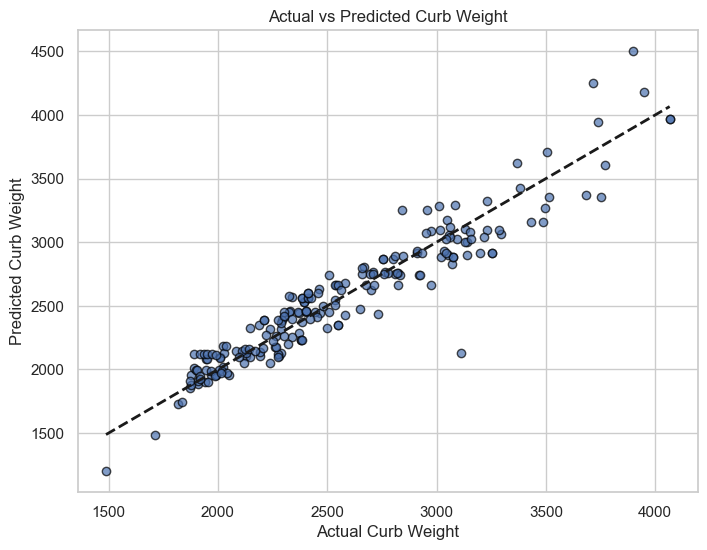

In [18]:
from sklearn.model_selection import cross_val_predict

predicted = cross_val_predict(model4, X, y, cv=k)

plt.figure(figsize=(8, 6))
plt.scatter(y, predicted, edgecolors=(0, 0, 0), alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Removed redundant color='red'
plt.xlabel('Actual Curb Weight')
plt.ylabel('Predicted Curb Weight')
plt.title('Actual vs Predicted Curb Weight')
plt.show()

# Reference:

https://archive.ics.uci.edu/ml/datasets/Automobile  
https://en.wikipedia.org/wiki/List_of_Renault_engines#J  
http://portal.enginedesk.net/model/renault/master_i/22_type_30_box/parts/167750/2106/BOD